# <center> Tarea 2: Geometria Computacional y Diferencial</center>
<center>Juan Manuel Ramirez Osuna</center>

## Librerias necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Primera pregunta:
## Revision de direccion

In [2]:
# Clase vertice
# Input: Dos coordenadas numericas
#        (opcional) Arista incidente, nombre, clasificacion y color
class vertex:
    def __init__(self,x,y, inci_edge = None, name = None, typ = None, col = None):
        self.x = x
        self.y = y
        self.name = name
        self.inci_edge = inci_edge
        self.typ = typ
        self.col = col
    
    def __repr__(self):
        return f'({self.x},{self.y})'
    
    def __str__(self):
        return self.name
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    # Se definen como menores los puntos con mayor valor y o mismo valor y con menor valor x
    def __lt__(self, other):
        return self.y > other.y or (self.y == other.y and self.x < other.x)
    
    # Producto cruz (en 2 dimensiones)
    # Input: punto de origen y punto de destino
    # Output: flotante
    def cross_prod(self, orig, obj):
        return (obj.x - orig.x)*(self.y-orig.y)-(obj.y-orig.y)*(self.x-orig.x)
    
    # Cadena
    # Input: cara con respecto a la que se quiere identificar la posicion
    # Output: string de direccion
    # Revisa la direccion del punto asumiendo que es regular segun el orden de sus vertices anterior 
    # y siguiente
    def chain(self, face):
        siguiente = self.inci_edge
        while siguiente.inci_face != face:
            if siguiente.ini ==  self:
                siguiente = siguiente.prev_e
            else:
                siguiente = siguiente.twin
        siguiente = siguiente.fin
        anterior = self.inci_edge.prev_e
        while anterior.inci_face != face:
            if anterior.fin ==  self:
                anterior = anterior.next_e
            else:
                anterior = anterior.twin
        anterior = anterior.ini        
        if siguiente < self and self < anterior:
            return 'Right'
        else:
            return 'Left'

In [3]:
# A vertices
# Input: lista de pares de flotantes
# Output: lista de vertices
def to_vert(lt):
    return [vertex(x[0], x[1], name = f'v{i}') for i,x in enumerate(lt)]

In [4]:
# Revisar rotacion
# Input: lista de vertices
# Verifica el menor vertice y verifica la rotacion que se realiza sobre este, si es a derecha se
# considera una rotacion en sentido de las manecillas del reloj y se invierte la lista, adicionalmente
# elimina el ultimo vertice en caso de que sea el mismo al primero
def check_rot(lv):
    menor = min(lv)
    anterior = vertices[vertices.index(menor)-1]
    siguiente = vertices[vertices.index(menor)+1]
    rot = anterior.cross_prod(menor,siguiente)
    if rot < 0:
        lv.reverse()
    if lv[0] == lv[-1]:
        lv.pop()

Lista de puntos inicial:
[[9.0, -1.0], [8.0, 6.0], [7.0, -3.0], [6.0, 3.0], [4.0, -4.0], [2.0, -4.0], [3.0, 4.0], [4.0, 2.5], [5.0, 12.0], [7.0, 12.0], [10.0, 6.0], [9.5, 11.0], [11.0, 15.0], [13.0, 15.0], [12.0, 10.0], [13.0, 3.0], [11.0, 4.0], [10.0, -1.0], [9.0, -1.0]]
Lista de puntos final:
[(9.0,-1.0), (10.0,-1.0), (11.0,4.0), (13.0,3.0), (12.0,10.0), (13.0,15.0), (11.0,15.0), (9.5,11.0), (10.0,6.0), (7.0,12.0), (5.0,12.0), (4.0,2.5), (3.0,4.0), (2.0,-4.0), (4.0,-4.0), (6.0,3.0), (7.0,-3.0), (8.0,6.0)]


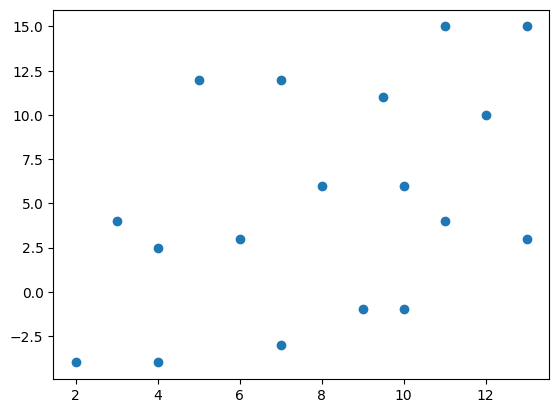

In [5]:
puntos = pd.read_csv('datos.txt').values.tolist()
print('Lista de puntos inicial:')
print(puntos)
vertices = to_vert(puntos)
check_rot(vertices)
print('Lista de puntos final:')
print(vertices)
xcoord = [i.x for i in vertices]
ycoord = [i.y for i in vertices]
plt.scatter(xcoord, ycoord)


# Segunda pregunta:
## Crear lista de semi aristas doblemente conectadas 

In [6]:
# Clase de semi aristas
# Input: Dos vertices
#        (Opcional) Semi arista gemela, semiarista siguiente, semi arista anterior, cara incidente, nombre
class semi_edge:
    def __init__(self, v1, v2, twin = None, next_e = None, prev_e = None, inci_face = None, name = None):
        self.ini = v1
        self.fin = v2
        self.twin = twin
        self.next_e = next_e
        self.prev_e = prev_e
        self.name = name
        self.inci_face = inci_face
    
    def __repr__(self):
        return f'{self.ini} ---> {self.fin}'
                 
    def __str__(self):
        return self.name
    
    def __eq__(self, other):
        return (self.ini == other.ini) and (self.fin == other.fin)

In [7]:
# Construir poligono simple de semi aristas
# Input: Lista de vertices
# Output: Lista de semiaristas conectadas
def build_simple_se(lv):
    aux = lv.copy()
    aux.append(aux.pop(0))
    aux = [*zip(lv, aux)]
    aux2 = []
    for i in range(len(aux)): # Fase de creacion
        aux2.extend([semi_edge(aux[i][0], aux[i][1], name = f'e{i}0'),\
                     semi_edge(aux[i][1], aux[i][0], name = f'e{i}1')])
    for i in range(-2,len(aux2)-2,2): # Fase de conexion (por twins)
        aux2[i].twin = aux2[i+1] # Conexion de twins
        aux2[i+1].twin = aux2[i]
        
        aux2[i].next_e = aux2[i+2] # Conexion de siguientes
        aux2[i+1].next_e = aux2[i-1] # Direccion contraria
        
        aux2[i].prev_e = aux2[i-2] # Conexion de anteriors
        aux2[i+1].prev_e = aux2[i+3]
        
        lv[i//2].inci_edge = aux2[i] # Aristas incidentes de vertices
    return aux2

In [8]:
# Clase cara
# Input: Nombre
#        (opcional) Lista de semi aristas, lista de vertices y lado
class face:
    def __init__(self, name, s_e = [], v = [], side = 'Unknown'):
        self.name = name
        self.s_e = s_e
        self.v = v
        self.side = side
        
    def __repr__(self):
        return f'{self.s_e}'
    
    def __str__(self):
        return self.name
    
    # Definir
    # Define si la cara es exterior o interior
    def define(self):
        mn = min(self.v)
        for e in self.s_e:
            if e.ini == mn:
                nex = e.fin
            elif e.fin == mn:
                pre = e.ini
        turn = nex.cross_prod(pre, mn) # Se usa la definicion de rotacion cambiando el uso del giro
        if turn > 0:
            self.side = 'Exterior'
        elif turn < 0:
            self.side = 'Interior'
    
    # Graficar
    # Grafica los vertices y las aristas direccionadas que componen la cara
    def plot(self):
        xcoord = [v.x for v in self.v]
        ycoord = [v.y for v in self.v]
        plt.scatter(xcoord,ycoord)
        for v in self.v:
            plt.annotate(v.name, (v.x,v.y))
        for e in self.s_e:
            plt.arrow(e.ini.x, e.ini.y, e.fin.x-e.ini.x, e.fin.y-e.ini.y, head_width=0.25)
        plt.show()

In [9]:
# Clase de lista de aristas doblemente conectads
# Input: Lista de vertices y lista de semi aristas
class dc_edge_list:
    def __init__(self, lv, lse):
        self.v = lv        
        self.s_e = lse
        self.f = []
        self.faces()
    
    # Constructor de caras
    # Recorre cada semi aristas, en caso de no tener caras busca su ciclo mediante sus aristas siguientes
    # y define las caras
    def faces(self):
        count = 0;
        for i in range(len(self.s_e)):
            initial = self.s_e[i]
            if initial.inci_face is None:
                h = face(f'h{count}', s_e = [initial], v = [initial.fin])
                initial.inci_face = h
                self.f.append(h)
                count += 1
                current = initial.next_e
                while True:
                    current.inci_face = h
                    h.s_e.append(current)
                    h.v.append(current.fin)
                    if current.next_e == initial:
                        break
                    current = current.next_e
        for h in self.f:
            h.define()                 
    
    # Reiniciar caras
    # Elimina todas las caras
    def reset_faces(self):
        self.f = []
        for e in self.s_e:
            e.inci_face = None
    
    # Actualizar
    # Input: par de vertices de la nueva aristas
    #        (opcional) booleano para describir procesos
    # Crea las nuevas semi-aristas, las conecta y crea las nuevas caras
    def update(self, pv, verbose = False):
        pv = [x for x in self.v if  x in pv]
        new_e = [semi_edge(pv[0], pv[1], name=f'e{int(self.s_e[-1].name[1:-1])+1}0'),\
                semi_edge(pv[1], pv[0], name=f'e{int(self.s_e[-1].name[1:-1])+1}1')]
        new_e[0].twin = new_e[1]
        new_e[1].twin = new_e[0]
        if verbose:
            print('aristas creadas')
            print(new_e)
        aux_a = [pv[0].inci_edge]
        current = pv[0].inci_edge.twin
        while current != aux_a[0]:
            if verbose:
                print(f'Revisando {current}')
            if current.ini == pv[0]:
                if current.inci_face.side == 'Exterior':
                    aux_a.append(current)
                current = current.twin
            else:
                current = current.next_e
        if verbose:
            print('Candidatos de a')
            print(aux_a)
        aux_b = [pv[1].inci_edge]
        current = pv[1].inci_edge.twin
        while current != aux_b[0]:
            if verbose:
                print(f'Revisando {current}')
            if current.ini == pv[1]:
                if current.inci_face.side == 'Exterior':
                    aux_b.append(current)
                current = current.twin
            else:
                current = current.next_e
        if verbose:
            print('Candidatos de b')
            print(aux_b)
        for a in aux_a:
            for b in aux_b:
                if a.inci_face == b.inci_face:
                    new_a = a
                    new_b = b
                    break
        if verbose:
            print(f'a = {new_a}: {repr(new_a)}')
            print(f'b = {new_b}: {repr(new_b)}')
        new_a.prev_e.next_e = new_e[0]
        new_b.prev_e.next_e = new_e[1]
        new_e[0].prev_e = new_a.prev_e
        new_e[1].prev_e = new_b.prev_e
        new_e[0].next_e = new_b
        new_e[1].next_e = new_a
        new_b.prev_e = new_e[0]
        new_a.prev_e = new_e[1]
        self.s_e.extend(new_e)
        self.reset_faces()
        self.faces()
    
    # Triangular y monotono
    # Input: (opcional) booleano para describir procesos
    # Aplica algoritmo de triangulacion sobre poligonos y monotonos
    def triangulate_y_mono(self, verbose = False):
        D = []
        for c in self.f:
            if c.side == 'Exterior':
                if verbose:
                    print(f'Revisando la cara {c.name}')
                    c.plot()
                aux = c.v.copy()
                aux.sort()
                S = [aux[0], aux[1]]
                if verbose:
                    print(f'Pila inicial: {S}')
                for i in range(2,len(aux)-1):
                    if verbose:
                        print(f'Revisando {aux[i]}')
                    if aux[i].chain(c) != S[-1].chain(c):
                        if verbose:
                            print(f'{aux[i]} y {S[-1]} en cadenas distintas')
                        while len(S) > 1:
                            out = S.pop()
                            if verbose:
                                print(f'Diagonal entre {aux[i]} y {out}')
                            D.append([aux[i], out])
                        S.pop()
                        S.append(aux[i-1])
                        S.append(aux[i])
                    else:
                        if verbose:
                            print(f'{aux[i]} y {S[-1]} en cadenas iguales')
                        last = S.pop()
                        while len(S) > 0:
                            current = S[-1]
                            if verbose:
                                print(f'En cadena: {aux[i].chain(c)}')
                                print(f'Pila de paso: {S}')
                                print(f'Revisando conexion con {current}')
                            if aux[i].chain(c) == 'Right':
                                if verbose:
                                    print(f'Anterior: {last}')
                                if last.cross_prod(aux[i], current) < 0:
                                    if verbose:
                                        print(f'Diagonal valida entre {aux[i]} y {current}')
                                    last = S.pop()
                                    D.append([aux[i], current])
                                else:
                                    break
                            else:
                                if verbose:
                                    print(f'Anterior: {last}')
                                if last.cross_prod(aux[i], current) > 0:
                                    if verbose:
                                        print(f'Diagonal valida entre {aux[i]} y {current}')
                                    last = S.pop()
                                    D.append([aux[i], current])
                                else:
                                    break
                        S.append(last)
                        S.append(aux[i])
                    if verbose:
                        print(f'Pila final del paso: {S}')
                S.pop()
                S.pop(0)
                if verbose:
                    print(f'Trazar diagonales entre {aux[-1]} y {S}')
        for v in D:
            self.update(v)
        for v in S:
            self.update([aux[-1],v])

    # Coloracion
    # Input: (opcional) booleano para describir procesos
    # Output: Color con menor cantidad de vertices
    def color(self, step = False):
        revisar = [self.v[0]]
        sample = ['blue', 'red', 'green']
        count = [0, 0, 0]
        for v in revisar:
            colors = [x for _,x in sorted(zip(count,sample), reverse=True)]
            if step:
                print(f'Revisando {v}')
            if v.col == None:
                initial = v.inci_edge
                if step:
                        print(f'Revisando arista {initial}')
                if initial.fin.col in colors:
                    colors.remove(initial.fin.col)
                current = initial.twin
                while current != initial:
                    if step:
                        print(f'Revisando arista {current}')
                    if current.ini == v:
                        if current.fin.col in colors:
                            if step:
                                print(f'Vecino {current.fin} borra {current.fin.col}')
                            colors.remove(current.fin.col)
                            if len(colors) == 0:
                                if step:
                                    print(f'Sin colores, borrando vecino anterior')
                                current.fin.col = None
                                revisar.append(current.fin)
                                revisar.append(v)
                        elif current.fin not in revisar:
                            revisar.append(current.fin)
                            if len(colors) == 0:
                                current.fin.col = None
                        current = current.twin
                    else:
                        current = current.next_e
                if len(colors) != 0:
                    if step:
                        print(f'Posibles colores: {colors}')
                    v.col = colors.pop()
                    count[sample.index(v.col)] += 1
                    if step:
                        print(f'Posibles colores: {colors}')
                        print(f'Selecciona {v.col}')
                        print('Conteo:')
                        print(sample)
                        print(count)
                if step:
                    self.plot_color()
                
        return sample[count.index(min(count))]
    
    # Lista
    # Output: DataFrame de pandas con la informacion de las semi aristas
    def lista(self):
        semi_edges = []
        origin = []
        twin = []
        inci_face = []
        next_e = []
        prev_e = []
        for i in range(len(self.s_e)):
            semi_edges.append(self.s_e[i].name)
            origin.append(self.s_e[i].ini)
            twin.append(self.s_e[i].twin)
            inci_face.append(self.s_e[i].inci_face)
            next_e.append(self.s_e[i].next_e)
            prev_e.append(self.s_e[i].prev_e)
        return pd.DataFrame.from_dict({'Semi Aristas': semi_edges, 'Origen': origin,\
                                       'Twin': twin, 'Cara incidente': inci_face,\
                                       'Next': next_e, 'Prev': prev_e})
    
    # Graficar
    # Grafica los vertices y las aristas no direccionadas de la lista
    def plot(self):
        xcoord = [v.x for v in self.v]
        ycoord = [v.y for v in self.v]
        plt.scatter(xcoord,ycoord)
        for v in self.v:
            plt.annotate(v.name, (v.x,v.y))
        for e in self.s_e:
            plt.plot([e.ini.x, e.fin.x], [e.ini.y, e.fin.y])
        plt.show()
    
    # Graficar colores
    # Grafica los vertices con su color y las semi aristas de la lista
    def plot_color(self):
        for v in self.v:
            if v.col == 'red':
                plt.scatter(v.x,v.y, color = v.col, s=100)
            elif v.col == 'green':
                plt.scatter(v.x,v.y, color = v.col, s=100)
            elif v.col == 'blue':
                plt.scatter(v.x,v.y, color = v.col, s=100)
            else:
                print('Error')
            plt.annotate(v.name, (v.x,v.y))
            
        for e in self.s_e:
            plt.plot([e.ini.x, e.fin.x], [e.ini.y, e.fin.y])
        plt.show()
    
    # Graficar camaras
    # Input: String de color
    # Grafica losv vertices del color que s
    def plot_camera(self, color):
        for v in self.v:
            if v.col == color:
                plt.scatter(v.x,v.y, color = color, s=100)
            else:
                plt.scatter(v.x,v.y)
            plt.annotate(v.name, (v.x,v.y))
            
        for e in self.s_e:
            plt.plot([e.ini.x, e.fin.x], [e.ini.y, e.fin.y])
        plt.show()

Poligono simple:


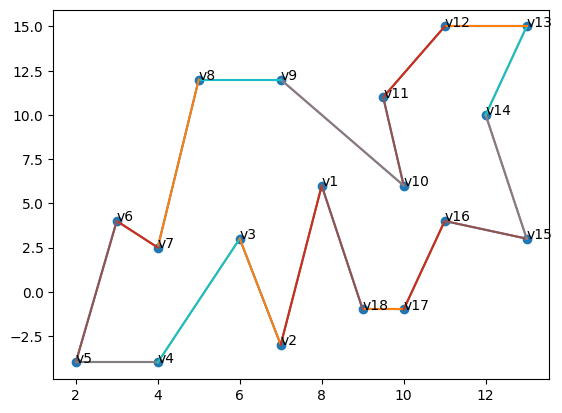

,Semi Aristas,Origen,Twin,Cara incidente,Next,Prev
0,e00,v18,e01,h0,e10,e170
1,e01,v17,e00,h1,e171,e11
2,e10,v17,e11,h0,e20,e00
3,e11,v16,e10,h1,e01,e21
4,e20,v16,e21,h0,e30,e10
5,e21,v15,e20,h1,e11,e31
6,e30,v15,e31,h0,e40,e20
7,e31,v14,e30,h1,e21,e41
8,e40,v14,e41,h0,e50,e30
9,e41,v13,e40,h1,e31,e51


In [10]:
semiaristas = build_simple_se(vertices)

aristas_doblemente_conectadas = dc_edge_list(vertices, semiaristas)

print('Poligono simple:')
aristas_doblemente_conectadas.plot()
aristas_doblemente_conectadas.lista()

# Tercera pregunta:
## Particiones y-monotonas

In [11]:
# Clase arista
# Input: Dos vertices
#        (opcional) siguiente arista, anterior arista, nombre
class edge:
    def __init__(self, v1, v2, next_e = None, prev_e = None, name = None):
        self.ini = v1
        self.fin = v2
        self.next_e = next_e
        self.prev_e = prev_e
        self.name = name
    
    def __repr__(self):
        return f'{self.ini} ---> {self.fin}'
                 
    def __str__(self):
        return self.name
    
    def __eq__(self, other):
        return (self.ini == other.ini) and (self.fin == other.fin)
    
    # Mitad
    # Input: Coordenada y de punto a revisar
    # Output: par de coordenadas de interseccion de la arista con el valor de y
    def middle(self, y_new):
        if self.ini.y == self.fin.y:
            return [self.ini.x, y_new]
        alpha = (y_new - self.fin.y)/(self.ini.y - self.fin.y)
        x_new = self.fin.x + alpha*(self.ini.x - self.fin.x)
        return [round(x_new,4), y_new]

In [12]:
# Construir poligono simple de aristas
# Input: Lista de vertices
# Output: Lista de aristas
def build_simple_e(lv):
    aux = lv.copy()
    aux.append(aux.pop(0))
    aux = [*zip(lv, aux)]
    aux = [edge(x[0], x[1], name = f'e{i}') for i,x in enumerate(aux)]
    for i in range(-1,len(aux)-1):      
        aux[i].next_e = aux[i+1]
        aux[i].prev_e = aux[i-1]
        lv[i].inci_edge = aux[i]
    return aux

In [13]:
# Clase de lista de aristas
class edge_list:
    def __init__(self, lv, le):
        self.v = lv        
        self.edges = le
        self.classify()
    
    # Clasificar
    # Clasifica los vertices como division, inicial, union, final o regular segun su posicion con respecto
    # a sus vecinos y la rotacion formada entre estos
    def classify(self):
        for v in self.v:
            for e in self.edges:
                if e.ini == v:
                    nex = e.fin
                elif e.fin == v:
                    pre = e.ini
            if v < nex and v < pre:
                turn = nex.cross_prod(pre, v)
                if turn < 0:
                    v.typ = 'Div'
                elif turn > 0:
                    v.typ = 'Ini'
            elif nex < v and pre < v:
                turn = nex.cross_prod(pre, v)
                if turn < 0:
                    v.typ = 'Mer'
                elif turn > 0:
                    v.typ = 'Fin'
            else:
                v.typ = 'Reg'
    
    # Lista
    # Output: DataFrame de Pandas con informacion de las aristas
    def lista(self):
        edges = []
        origin = []
        next_e = []
        prev_e = []
        typ = []
        for i in range(len(self.edges)):
            edges.append(self.edges[i].name)
            origin.append(self.edges[i].ini)
            next_e.append(self.edges[i].next_e)
            prev_e.append(self.edges[i].prev_e)
        return pd.DataFrame.from_dict({'Aristas': edges, 'Origen': origin, 'Next': next_e, 'Prev': prev_e})
    
    # Graficar direccion
    # Grafica los vertices y las aristas direcionadas de la lista
    def plot_dir(self):
        xcoord = [v.x for v in self.v]
        ycoord = [v.y for v in self.v]
        plt.scatter(xcoord,ycoord)
        for v in self.v:
            plt.annotate(v.name, (v.x,v.y))
        for e in self.edges:
            plt.arrow(e.ini.x, e.ini.y, e.fin.x-e.ini.x, e.fin.y-e.ini.y, head_width=0.25)
        plt.show()

    # Graficar tipos de vertices
    # Grafica los vertices segun su clasificacion y las aristas no direccionadas de la lista
    def plot_typ(self):
        for v in self.v:
            if v.typ == 'Div':
                plt.scatter(v.x,v.y, marker = '^', s = 100)
            elif v.typ == 'Mer':
                plt.scatter(v.x,v.y, marker = 'v', s = 100)
            elif v.typ == 'Ini':
                plt.scatter(v.x,v.y, marker = '*', s = 100)
            elif v.typ == 'Fin':
                plt.scatter(v.x,v.y, marker = 's', s = 100)
            elif v.typ == 'Reg':
                plt.scatter(v.x,v.y, s = 100)
            else:
                print('Error')
            plt.annotate(v.name, (v.x,v.y))
        for e in self.edges:
            plt.plot([e.ini.x, e.fin.x], [e.ini.y, e.fin.y])
        plt.show()

In [14]:
# Clase nodo
# Input: valor, ayudante
#        (opcional) dos nodos hijos, nodo padre
class Node:
    def __init__(self, val, helper, lc = None, rc = None, parent = None):
        self.val = val
        self.helper = helper
        self.lc = lc
        self.rc = rc
        self.parent = parent

# Insertar
# Input: Nodo raiz, nuevo valor, ayudante, punto y para orden
#        (opcional) nodo padre
# Inserta puntos al arbol ordenado segun el ordenamiento de la clase vertice            
def insert(root, new, helper, y, parent = None):
    if root is None:
        return Node(new, helper)
    elif new.middle(y) < root.val.middle(y):
        root.lc = insert(root.lc, new, helper, y, parent = root)
    else:
        root.rc = insert(root.rc, new, helper, y, parent = root)
    return root

# Borrar
# Input: Nodo raiz, segmento a borrar
# Output: Nodo raiz
# Se busca el nodo correspondiente al segmento, se convierte en nulo o reemplaza por el siguiente nodo 
# correspondiente y se realizan los reordenamientos necesarios
def delete(root, ded):
    if root is not None:
        if ded == root.val:
            if root.rc is not None:
                if root.lc:
                    smallest = find_smallest_seg(root.rc)
                    if smallest == root.rc:
                        root.val = root.rc.val
                        root.helper = root.rc.helper
                        root.rc = root.rc.rc  
                    else:
                        new_val = smallest.val
                        new_helper = smallest.helper
                        delete(root.rc, new_val)
                        root.val = new_val
                        root.helper = new_helper
                        root.rc.parent = root
                else:
                    root.val = root.rc.val
                    root.helper = root.rc.helper
                    root.lc = root.rc.lc
                    root.rc = root.rc.rc                        
            elif root.lc != None:
                root.val = root.lc.val
                root.helper = root.lc.helper
                root.rc = root.lc.rc
                root.lc = root.lc.lc
            else:
                if not root.parent:
                    return None
        else:
            if root.lc:
                if root.lc.val == ded:
                    if root.lc.lc or root.lc.rc:
                        delete(root.lc, ded)
                    else:
                        root.lc = None
                else: 
                    delete(root.lc, ded)
            if root.rc:
                if root.rc.val == ded:
                    if root.rc.lc or root.rc.rc:
                        delete(root.rc, ded)
                    else:
                         root.rc = None
                else:
                    delete(root.rc, ded)
    return root

# Encontrar menor segmento
# Input: Nodo raiz
# Output: Nodo
def find_smallest_seg(root):
    if root.lc == None:
        return root
    else:
        return find_smallest_seg(root.lc)
        
def find_left(root, v, node = None):
    if  root.val.middle(v.y)[0] < v.x :
        if root.rc:
            return find_left(root.rc, v, root)
        else:
            return root
    else:
        if node:
            if root.lc:
                return find_left(root.lc, v)
            else:
                return node
        else:
            if root.lc:
                return find_left(root.lc,v)

# En orden
# Input: Nodo raiz
# Output: Lista de lista en formato [Valor, segmento] ordenados segun el valor del punto
def inorder(root):
    result = [] 
    if root:
        result.extend(inorder(root.lc))
        result.append(root.val)
        result.extend(inorder(root.rc))
    return result

# Encontrar ayudante
# Input: Nodo raiz, arista
# Output: Vertice ayudante de la arista
def find_helper(root, edge):
    if root.val == edge:
        return root.helper
    else:
        aux = None
        if root.rc != None:
            aux = find_helper(root.rc, edge)
        if not aux and root.lc != None:
            aux = find_helper(root.lc, edge)
        return aux

In [15]:
# Division a y monotono
# Input: lista de vertices, lista de arista
#        (opcional) Booleano para presentar procedimientos
# Output: lista de vertices a conectar
def divs_ymono(lv, le, verbose = False):
    aux = lv.copy()
    aux.sort(reverse=True)
    tau = None
    connections = []
    while len(aux) > 0:
        current = aux.pop()
        if verbose:
            print(f'Revisando {current}')
        if current.typ == 'Ini':
            tau = insert(tau, current.inci_edge, current, current.y)
        elif current.typ == 'Fin':
            if find_helper(tau, current.inci_edge.prev_e).typ == 'Mer':
                if verbose:
                    print(f'Conectar con {find_helper(tau, current.inci_edge.prev_e)}')
                connections.append([current, find_helper(tau, current.inci_edge.prev_e)])
            tau = delete(tau, current.inci_edge.prev_e)
        elif current.typ == 'Div': 
            left = find_left(tau, current)
            if verbose:
                print(f'Conectar con {left.helper}')
            connections.append([current, left.helper])
            left.helper = current
            tau = insert(tau, current.inci_edge, current, current.y)
        elif current.typ == 'Mer':
            if find_helper(tau, current.inci_edge.prev_e).typ == 'Mer':
                if verbose:
                    print(f'Conectar con {find_helper(tau, current.inci_edge.prev_e)}')
                connections.append([current, find_helper(tau, current.inci_edge.prev_e)])
            tau = delete(tau, current.inci_edge.prev_e)
            left = find_left(tau, current)
            if left.helper.typ == 'Mer':
                if verbose:
                    print(f'Conectar con {left.helper}')
                connections.append([current, left.helper])
            left.helper = current     
        elif current.typ == 'Reg':
            if current.inci_edge.prev_e.ini < current and current < current.inci_edge.fin:
                if find_helper(tau, current.inci_edge.prev_e).typ == 'Mer':
                    if verbose:
                        print(f'Conectar con {find_helper(tau, current.inci_edge.prev_e)}')
                    connections.append([current, find_helper(tau, current.inci_edge.prev_e)])
                tau = delete(tau, current.inci_edge.prev_e)
                tau = insert(tau, current.inci_edge, current, current.y)
            else:
                left = find_left(tau, current)
                if left.helper.typ == 'Mer':
                    if verbose:
                        print(f'Conectar con {left.helper}')
                    connections.append([current, left.helper])
                left.helper = current     
        else:
            print('Error')
        if verbose:
            print(inorder(tau))
    if verbose:
        print(connections)
    return connections         

Poligono clasificado:


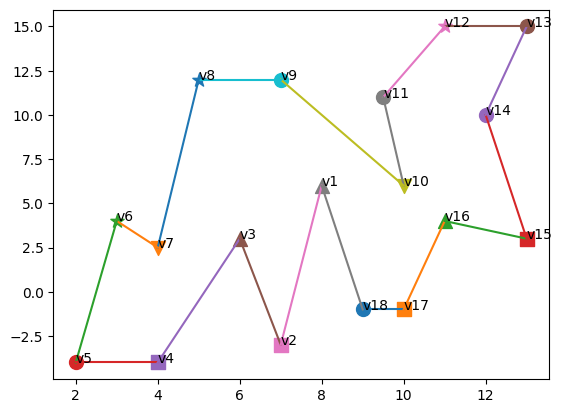

[[(8.0,6.0), (7.0,12.0)], [(11.0,4.0), (10.0,6.0)], [(6.0,3.0), (8.0,6.0)], [(2.0,-4.0), (4.0,2.5)]]
Poligono en segmentos y-monotonos


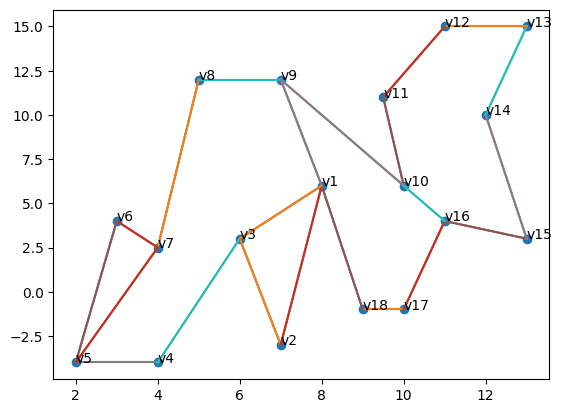

,Semi Aristas,Origen,Twin,Cara incidente,Next,Prev
0,e00,v18,e01,h0,e10,e170
1,e01,v17,e00,h1,e171,e11
2,e10,v17,e11,h0,e190,e00
3,e11,v16,e10,h1,e01,e21
4,e20,v16,e21,h2,e30,e191
5,e21,v15,e20,h1,e11,e31
6,e30,v15,e31,h2,e40,e20
7,e31,v14,e30,h1,e21,e41
8,e40,v14,e41,h2,e50,e30
9,e41,v13,e40,h1,e31,e51


In [16]:
vertices = to_vert(puntos)
check_rot(vertices)

aristas = build_simple_e(vertices)
aristas_conectadas = edge_list(vertices, aristas)
print('Poligono clasificado:')
aristas_conectadas.plot_typ()

new_edges = divs_ymono(vertices, aristas)
print(new_edges)
for e in new_edges:
    aristas_doblemente_conectadas.update(e)
    
print('Poligono en segmentos y-monotonos')
aristas_doblemente_conectadas.plot()
aristas_doblemente_conectadas.lista()

# Cuarta pregunta:
## Triangulacion sobre particiones y-monotonas

Poligono triangulado


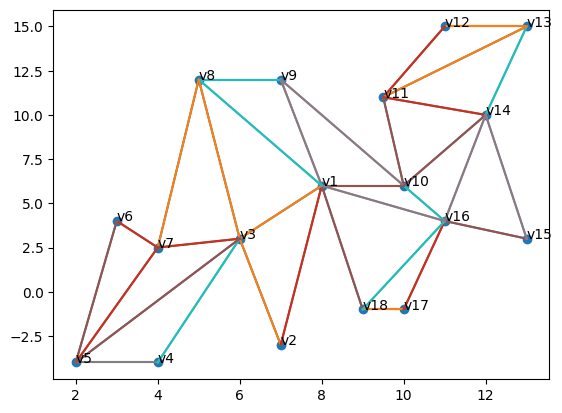

In [17]:
aristas_doblemente_conectadas.triangulate_y_mono()
print('Poligono triangulado')
aristas_doblemente_conectadas.plot()

# Quinta pregunta:
## Colocar camaras

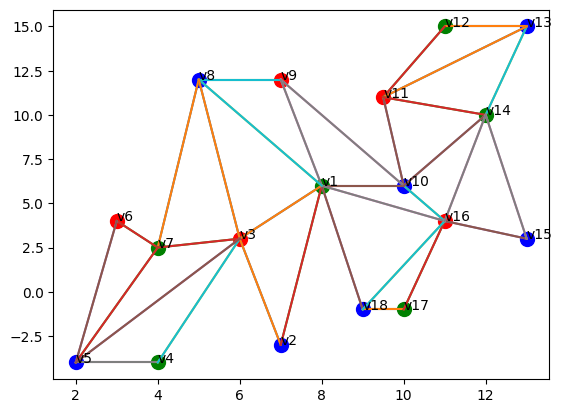

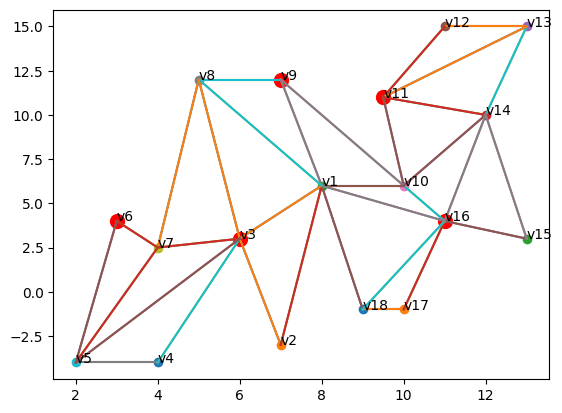

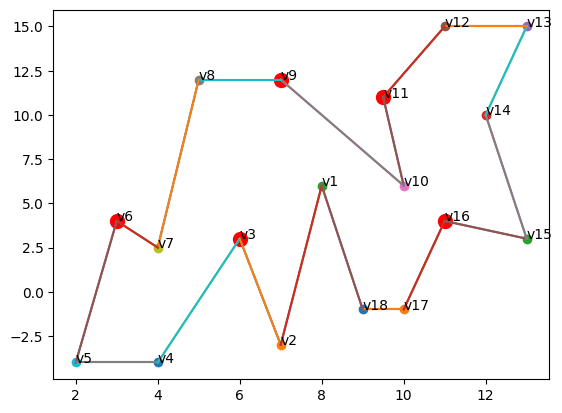

In [18]:
color = aristas_doblemente_conectadas.color()
aristas_doblemente_conectadas.plot_color()
aristas_doblemente_conectadas.plot_camera(color)

semiaristas_simple = build_simple_se(aristas_doblemente_conectadas.v)
aristas_doblemente_conectadas_simple = dc_edge_list(aristas_doblemente_conectadas.v, semiaristas_simple)
aristas_doblemente_conectadas_simple.plot_camera(color)

## Bibliografia
- GeeksforGeeks. (2023, February 15). Graph coloring: Set 2 (greedy algorithm). https://www.geeksforgeeks.org/graph-coloring-set-2-greedy-algorithm/ 
- Gervais. N. (2021, April 2). Sorting list according to corresponding values from a parallel list. Stack Overflow. https://stackoverflow.com/questions/6618515/sorting-list-according-to-corresponding-values-from-a-parallel-list 
